In [1]:
%%sh
rm -r sample_data
pip install --upgrade pandas
pip install --upgrade geopandas
pip install --upgrade fastparquet
pip install --upgrade pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 38.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 9.0.0
    Uninstalling pyarrow-9.0.0:
      Successfully uninstalled pyarrow-9.0.0


rm: cannot remove 'sample_data': No such file or directory
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.


In [1]:
from google.colab import drive

import os
import ftplib

import requests
from bs4 import BeautifulSoup
from urllib import request

import pandas as pd
import numpy as np
import geopandas as gpd

from multiprocessing import Pool

from numba import jit
import time

from IPython.display import clear_output
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', message = '.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message = '.*Geometry is in a geographic CRS.*')

import matplotlib.pyplot as plt
import seaborn as sns

import gc

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
pasta_projeto = 'drive/MyDrive/Aprendizado_Maquina/Projeto_Empresas'

# Baixa Dados Abertos de CNPJ e Indicadores do Serasa

In [5]:
#Arquivos baixados do Portal de Dados Abertos
#https://dados.gov.br/dados/conjuntos-dados/cadastro-nacional-da-pessoa-jurdica---cnpj
#https://dadosabertos.rfb.gov.br/CNPJ/

url = 'https://dadosabertos.rfb.gov.br/CNPJ/'
page = requests.get(url)    
data = page.text
soup = BeautifulSoup(data)

os.system('mkdir dados_abertos')
for link in soup.find_all('a'):
    if str(link.get('href')).endswith('.zip'):
        cam = link.get('href')
        if not cam.startswith('http'):
            link = url+cam
        else:
            link = cam
        print(link) 
        request.urlretrieve(link, 'dados_abertos/'+cam)

https://dadosabertos.rfb.gov.br/CNPJ/Cnaes.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas0.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas1.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas2.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas3.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas4.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas5.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas6.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas7.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas8.zip
https://dadosabertos.rfb.gov.br/CNPJ/Empresas9.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos0.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos1.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos2.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos3.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos4.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos5.zip
https://dadosabertos.rfb.gov.br/CNPJ/Estabelecimentos6.zip
https://dadosabertos.rfb.gov.b

In [6]:
#Arquivos Baixados do Serasa Experian - Indicadores Econômicos
#https://www.serasaexperian.com.br/conteudos/indicadores-economicos/

url = 'https://www.serasaexperian.com.br/images-cms/wp-content/uploads/2021/01/Falencias-e-Recuperacoes-10.xlsx'

os.system('mkdir dados_serasa')
print(url)
request.urlretrieve(url, 'dados_serasa/'+ 'Falencias-e-Recuperacoes-10.xlsx')

https://www.serasaexperian.com.br/images-cms/wp-content/uploads/2021/01/Falencias-e-Recuperacoes-10.xlsx


('dados_serasa/Falencias-e-Recuperacoes-10.xlsx',
 <http.client.HTTPMessage at 0x7f017f4a5f40>)

# Trata Dados

In [10]:
os.system('mkdir dados_tratados')

0

In [11]:
def salva_parquet_empresas(df, i, j):
    df.columns = ['CNPJ_RAIZ', 'NOME', 'COD_NATUREZA_JURIDICA', 'QUALIFICACAO_RESPONSAVEL', 
                  'CAPITAL_SOCIAL', 'PORTE_EMPRESA', 'ENTE_FEDERATIVO_RESP']
    cols_str = ['CNPJ_RAIZ', 'NOME', 'COD_NATUREZA_JURIDICA', 'QUALIFICACAO_RESPONSAVEL', 'PORTE_EMPRESA', 
                'ENTE_FEDERATIVO_RESP']
    for c in cols_str:
        df[c] = df[c].str.strip()
    df['arquivo'] = i
    df['parte'] = j
    try:
        df.to_parquet('dados_tratados/empresas', partition_cols = ['arquivo', 'parte'], index = False,
                    engine = 'fastparquet', compression = 'snappy', append = True)
    except:
        df.to_parquet('dados_tratados/empresas', partition_cols = ['arquivo', 'parte'], index = False,
                    engine = 'fastparquet', compression = 'snappy')

def trata_dados_empresas():
    lista_arq = sorted([f for f in os.listdir('dados_abertos') if 'Empresas' in f])
    i = 0
    for arq in lista_arq:
        print(arq)
        dict_dtypes = {0: str, 1: str, 2:str, 3:str, 4: float, 5:str, 6:str}
        iterchunks = pd.read_csv('dados_abertos/' + arq, sep = ';', decimal = ',', 
                                encoding = 'latin-1', low_memory = False, dtype = dict_dtypes,
                                index_col = None, header = None, chunksize = 100000)
        j = 0
        for df in iterchunks:
            salva_parquet_empresas(df, i, j)
            j = j + 1
        i = i + 1

os.system('rm dados_tratados/empresas -r')
trata_dados_empresas()

Empresas0.zip
Empresas1.zip
Empresas2.zip
Empresas3.zip
Empresas4.zip
Empresas5.zip
Empresas6.zip
Empresas7.zip
Empresas8.zip
Empresas9.zip


In [12]:
def salva_parquet_estabelecimentos(df, i, j):
    df.columns = ['CNPJ_RAIZ', 'CNPJ_ORDEM', 'CNPJ_DV', 'IDENT_MATRIZ_FILIAL', 'NOME_FANTASIA', 'SITUACAO_CADASTRAL',
                'DATA_SITUACAO_CADASTRAL', 'MOTIVO_SITUACAO_CADASTRAL', 'NOME_CIDADE_EXTERIOR', 'PAIS', 'DATA_INICIO_ATIVIDADE',
                'CNAE_PRINCIPAL', 'CNAE_SECUNDARIA', 'TIPO_LOGRADOURO', 'LOGRADOURO', 'NUMERO', 'COMPLEMENTO', 'BAIRRO', 'CEP',
                'UF', 'MUNICIPIO', 'DDD1', 'TELEFONE1', 'DDD2', 'TELEFONE2', 'DDD_FAX', 'FAX', 'EMAIL', 'SITUACAO_ESPECIAL',
                'DATA_SITUACAO_ESPECIAL']
    cols_str = ['CNPJ_RAIZ', 'CNPJ_ORDEM', 'CNPJ_DV', 'IDENT_MATRIZ_FILIAL', 'NOME_FANTASIA', 'SITUACAO_CADASTRAL',
                'MOTIVO_SITUACAO_CADASTRAL', 'NOME_CIDADE_EXTERIOR', 'PAIS', 'CNAE_PRINCIPAL', 'CNAE_SECUNDARIA', 
                'TIPO_LOGRADOURO', 'LOGRADOURO', 'NUMERO', 'COMPLEMENTO', 'BAIRRO', 'CEP', 'UF', 'MUNICIPIO', 'DDD1', 
                'TELEFONE1', 'DDD2', 'TELEFONE2', 'DDD_FAX', 'FAX', 'EMAIL', 'SITUACAO_ESPECIAL']
    for c in cols_str:
        df[c] = df[c].str.strip()
    cols_dt = ['DATA_SITUACAO_CADASTRAL', 'DATA_INICIO_ATIVIDADE', 'DATA_SITUACAO_ESPECIAL']
    for c in cols_dt:
        df[c] = pd.to_datetime(df[c], format = '%Y%m%d', errors = 'coerce')
    df['arquivo'] = i
    df['parte'] = j
    try:
        df.to_parquet('dados_tratados/estabelecimentos', partition_cols = ['arquivo', 'parte'], index = False,
                    engine = 'fastparquet', compression = 'snappy', append = True)
    except:
        df.to_parquet('dados_tratados/estabelecimentos', partition_cols = ['arquivo', 'parte'], index = False,
                    engine = 'fastparquet', compression = 'snappy')

def trata_dados_estabelecimentos():
    lista_arq = sorted([f for f in os.listdir('dados_abertos') if 'Estabelecimentos' in f])
    i = 0
    for arq in lista_arq:
        print(arq)
        iterchunks = pd.read_csv('dados_abertos/' + arq, sep = ';', decimal = ',', 
                                encoding = 'latin-1', low_memory = False, dtype = str,
                                index_col = None, header = None, chunksize = 100000)
        j = 0
        for df in iterchunks:
            salva_parquet_estabelecimentos(df, i, j)
            j = j + 1
        i = i + 1

os.system('rm dados_tratados/estabelecimentos -r')
trata_dados_estabelecimentos()

Estabelecimentos0.zip
Estabelecimentos1.zip
Estabelecimentos2.zip
Estabelecimentos3.zip
Estabelecimentos4.zip
Estabelecimentos5.zip
Estabelecimentos6.zip
Estabelecimentos7.zip
Estabelecimentos8.zip
Estabelecimentos9.zip


In [13]:
def salva_parquet_socios(df, i, j):
    df.columns = ['CNPJ_RAIZ', 'TIPO_PESSOA_SOCIO', 'NOME_SOCIO', 'CNPJ_CPF_SOCIO', 'QUALIFICACAO_SOCIO', 'DATA_ENTRADA_SOCIO',
                'PAIS', 'CPF_REPRESENTANTE', 'NOME_REPRESENTANTE', 'QUALIFICACAO_REPRESENTANTE', 'FAIXA_ETARIA_SOCIO']
    cols_str = ['CNPJ_RAIZ', 'TIPO_PESSOA_SOCIO', 'NOME_SOCIO', 'CNPJ_CPF_SOCIO', 'QUALIFICACAO_SOCIO',
                'PAIS', 'CPF_REPRESENTANTE', 'NOME_REPRESENTANTE', 'QUALIFICACAO_REPRESENTANTE', 'FAIXA_ETARIA_SOCIO']
    for c in cols_str:
        df[c] = df[c].str.strip()
    cols_dt = ['DATA_ENTRADA_SOCIO']
    for c in cols_dt:
        df[c] = pd.to_datetime(df[c], format = '%Y%m%d', errors = 'coerce')
    df['arquivo'] = i
    df['parte'] = j
    try:
        df.to_parquet('dados_tratados/socios', partition_cols = ['arquivo', 'parte'], index = False,
                    engine = 'fastparquet', compression = 'snappy', append = True)
    except:
        df.to_parquet('dados_tratados/socios', partition_cols = ['arquivo', 'parte'], index = False,
                    engine = 'fastparquet', compression = 'snappy')

def trata_dados_socios():
    lista_arq = sorted([f for f in os.listdir('dados_abertos') if 'Socios' in f])
    i = 0
    for arq in lista_arq:
        print(arq)
        iterchunks = pd.read_csv('dados_abertos/' + arq, sep = ';', decimal = ',', 
                                encoding = 'latin-1', low_memory = False, dtype = str,
                                index_col = None, header = None, chunksize = 100000)
        j = 0
        for df in iterchunks:
            #return df
            salva_parquet_socios(df, i, j)
            j = j + 1
        i = i + 1

os.system('rm dados_tratados/socios -r')
trata_dados_socios()

Socios0.zip
Socios1.zip
Socios2.zip
Socios3.zip
Socios4.zip
Socios5.zip
Socios6.zip
Socios7.zip
Socios8.zip
Socios9.zip


In [14]:
def trata_motivos():
    df = pd.read_csv('dados_abertos/Motivos.zip', sep = ';', decimal = ',', encoding = 'latin-1', 
                    low_memory = False, dtype = str, 
                    index_col = None, header = None)
    df.columns = ['MOTIVO_SITUACAO_CADASTRAL', 'DESCRICAO_MOTIVO_SITUACAO_CADASTRAL']
    for c in ['MOTIVO_SITUACAO_CADASTRAL', 'DESCRICAO_MOTIVO_SITUACAO_CADASTRAL']:
        df[c] = df[c].str.strip()
    df.to_parquet('dados_tratados/motivos.parquet', index = False, 
                  engine = 'pyarrow', compression = 'snappy')
    
trata_motivos()

In [15]:
#Peguei do PDF que está no FTP com o DePara
def trata_situacoes_cadastrais():
    df = pd.DataFrame(columns = ['SITUACAO_CADASTRAL', 'DESCRICAO_SITUACAO_CADASTRAL'])
    df.loc[len(df)] = ['01', 'NULA']
    df.loc[len(df)] = ['02', 'ATIVA']
    df.loc[len(df)] = ['03', 'SUSPENSA']
    df.loc[len(df)] = ['04', 'INAPTA']
    df.loc[len(df)] = ['08', 'BAIXADA']
    df.to_parquet('dados_tratados/situacoes_cadastrais.parquet', index = False, 
                  engine = 'pyarrow', compression = 'snappy')
    
trata_situacoes_cadastrais()

In [48]:
def trata_serasa_falencias_rj():
    df = pd.read_excel('dados_serasa/Falencias-e-Recuperacoes-10.xlsx', sheet_name = 'Total de Ocorrências',
                       skiprows = 2,
                       index_col = 0, header = [0, 1, 2])
    mask_nulos = (df.isna().sum(axis = 1) == df.shape[1])
    df = df[~mask_nulos]
    df.index = pd.to_datetime(df.index)
    df.to_csv('dados_tratados/falencias_rj.csv', index = True)

trata_serasa_falencias_rj()

In [40]:
#Salva Dados Tratados
command_cp = f'cp -r dados_tratados/ {pasta_projeto}/'
os.system(command_cp)

0

# Análise Exploratória

In [ ]:
#df_emp = pd.read_parquet('dados_tratados/empresas', engine = 'fastparquet')
#df_estab = pd.read_parquet('dados_tratados/estabelecimentos', engine = 'fastparquet')
#df_socios = pd.read_parquet('dados_tratados/socios', engine = 'fastparquet')

In [2]:
pd.read_parquet('dados_tratados/estabelecimentos/arquivo=0/parte=0', engine = 'fastparquet').columns

Index(['CNPJ_RAIZ', 'CNPJ_ORDEM', 'CNPJ_DV', 'IDENT_MATRIZ_FILIAL',
       'NOME_FANTASIA', 'SITUACAO_CADASTRAL', 'DATA_SITUACAO_CADASTRAL',
       'MOTIVO_SITUACAO_CADASTRAL', 'NOME_CIDADE_EXTERIOR', 'PAIS',
       'DATA_INICIO_ATIVIDADE', 'CNAE_PRINCIPAL', 'CNAE_SECUNDARIA',
       'TIPO_LOGRADOURO', 'LOGRADOURO', 'NUMERO', 'COMPLEMENTO', 'BAIRRO',
       'CEP', 'UF', 'MUNICIPIO', 'DDD1', 'TELEFONE1', 'DDD2', 'TELEFONE2',
       'DDD_FAX', 'FAX', 'EMAIL', 'SITUACAO_ESPECIAL',
       'DATA_SITUACAO_ESPECIAL'],
      dtype='object')

In [3]:
#cols_select = ['CNPJ_RAIZ', 'CNPJ_ORDEM', 'CNPJ_DV', 'NOME_FANTASIA', 'IDENT_MATRIZ_FILIAL', 'DATA_INICIO_ATIVIDADE',
#               'DATA_SITUACAO_CADASTRAL', 'SITUACAO_CADASTRAL', 'MOTIVO_SITUACAO_CADASTRAL']

cols_select = ['CNPJ_RAIZ', 'IDENT_MATRIZ_FILIAL', 'DATA_INICIO_ATIVIDADE',
               'DATA_SITUACAO_CADASTRAL', 'SITUACAO_CADASTRAL', 'MOTIVO_SITUACAO_CADASTRAL']

df_estab = pd.read_parquet('dados_tratados/estabelecimentos', engine = 'fastparquet',
                           columns = cols_select,
                           filters = [('IDENT_MATRIZ_FILIAL', '=', '1')])

In [4]:
df_sit = pd.read_parquet('dados_tratados/situacoes_cadastrais.parquet', engine = 'fastparquet')
df_motivos = pd.read_parquet('dados_tratados/motivos.parquet', engine = 'fastparquet')

In [5]:
df = pd.merge(df_estab, df_sit, how = 'left', on = 'SITUACAO_CADASTRAL')
df = pd.merge(df, df_motivos, how = 'left', on = 'MOTIVO_SITUACAO_CADASTRAL')

In [6]:
gc.collect()

0

In [7]:
df_agg = pd.DataFrame(df[['DESCRICAO_SITUACAO_CADASTRAL', 'DESCRICAO_MOTIVO_SITUACAO_CADASTRAL']].value_counts())
df_agg.columns = ['Qtd_Empresas']
df_agg['Perc_Empresas'] = df_agg['Qtd_Empresas']*100.0/df_agg['Qtd_Empresas'].sum()

In [8]:
df_agg[['Perc_Empresas']].reset_index().iloc[:10].style.format(precision = 1)

,DESCRICAO_SITUACAO_CADASTRAL,DESCRICAO_MOTIVO_SITUACAO_CADASTRAL,Perc_Empresas
0,ATIVA,SEM MOTIVO,40.4
1,BAIXADA,EXTINCAO POR ENCERRAMENTO LIQUIDACAO VOLUNTARIA,31.8
2,INAPTA,OMISSAO DE DECLARACOES,14.2
3,BAIXADA,INAPTIDAO (LEI 11.941/2009 ART.54),6.6
4,BAIXADA,REGISTRO CANCELADO,2.6
5,BAIXADA,OMISSAO CONTUMAZ,1.8
6,BAIXADA,EXTINCAO - TRATAMENTO DIFERENCIADO DADO AS ME E EPP (LEI COMPLEMENTAR NUMERO 123/2006),0.9
7,BAIXADA,INCORPORACAO,0.3
8,BAIXADA,BAIXA DE PRODUTOR RURAL,0.3
9,BAIXADA,OBITO DO MEI - TITULAR FALECIDO,0.3


In [9]:
dt_ini = pd.to_datetime(df['DATA_INICIO_ATIVIDADE'].min().strftime('%Y-%m-01')) + pd.DateOffset(months = 1)
dt_fim = pd.to_datetime(df['DATA_INICIO_ATIVIDADE'].max().strftime('%Y-%m-01'))
(dt_ini, dt_fim)

(Timestamp('1696-08-01 00:00:00'), Timestamp('2023-03-01 00:00:00'))

In [10]:
lista_datas = []
#dt = dt_ini
dt = pd.to_datetime('2000-01-01')
while dt <= dt_fim:
    lista_datas.append(dt)
    dt = dt + pd.DateOffset(months = 1)

In [11]:
lista_qtd_empresas = []
for dt in lista_datas:
    qtd_emp_abertas = (df['DATA_INICIO_ATIVIDADE'] <= dt).sum()
    qtd_emp_fechadas = ((df['DATA_SITUACAO_CADASTRAL'] <= dt) & (df['DESCRICAO_SITUACAO_CADASTRAL'] != 'ATIVA')).sum()
    qtd_emp_ativas = qtd_emp_abertas - qtd_emp_fechadas
    lista_qtd_empresas.append(qtd_emp_ativas)

    clear_output(wait = True)
    print(dt)
    print(qtd_emp_ativas)

2023-03-01 00:00:00
21757276


In [14]:
df_qtd_emp = pd.DataFrame(zip(lista_datas, lista_qtd_empresas), columns = ['Data_Ref', 'Qtd_Empresas_Ativas'])

In [16]:
os.system('mkdir analises_geradas')

0

In [17]:
#Salva Analise Gerada
df_qtd_emp.to_parquet('analises_geradas/empresas_ativas_tempo.parquet', index = False, 
                      engine = 'pyarrow', compression = 'snappy')

In [20]:
command_cp = f'cp -r analises_geradas/ {pasta_projeto}/'
os.system(command_cp)

0

# Plots

In [85]:
df_qtd_emp = pd.read_parquet('analises_geradas/empresas_ativas_tempo.parquet', engine = 'pyarrow')
df_qtd_emp = df_qtd_emp[df_qtd_emp['Data_Ref'] >= '2012-01-01']

In [65]:
df_serasa = pd.read_csv('dados_tratados/falencias_rj.csv', index_col = 0, header = [0, 1, 2])
df_serasa.index = pd.to_datetime(df_serasa.index)
df_serasa = df_serasa[df_serasa.index >= '2012-01-01']
list(df_serasa.columns)

[('Falências', 'Requeridas', 'Micro e Pequena Empresa'),
 ('Falências', 'Requeridas', 'Média Empresa'),
 ('Falências', 'Requeridas', 'Grande Empresa'),
 ('Falências', 'Requeridas', 'Total'),
 ('Falências', 'Decretadas', 'Micro e Pequena Empresa'),
 ('Falências', 'Decretadas', 'Média Empresa'),
 ('Falências', 'Decretadas', 'Grande Empresa'),
 ('Falências', 'Decretadas', 'Total'),
 ('Recuperações Judiciais', 'Requeridas', 'Micro e Pequena Empresa'),
 ('Recuperações Judiciais', 'Requeridas', 'Média Empresa'),
 ('Recuperações Judiciais', 'Requeridas', 'Grande Empresa'),
 ('Recuperações Judiciais', 'Requeridas', 'Total'),
 ('Recuperações Judiciais', 'Deferidas', 'Micro e Pequena Empresa'),
 ('Recuperações Judiciais', 'Deferidas', 'Média Empresa'),
 ('Recuperações Judiciais', 'Deferidas', 'Grande Empresa'),
 ('Recuperações Judiciais', 'Deferidas', 'Total'),
 ('Recuperações Judiciais', 'Concedidas', 'Total'),
 ('Concordatas', 'Requeridas', 'Total'),
 ('Concordatas', 'Deferidas', 'Total')]

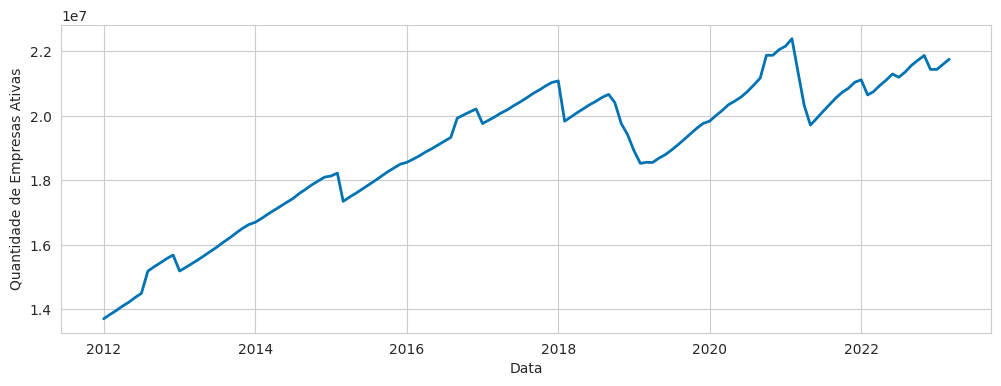

In [86]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize = (12, 4))
    ax.plot(df_qtd_emp['Data_Ref'], df_qtd_emp['Qtd_Empresas_Ativas'], lw = 2, color = paleta_cores[0])
    ax.set_xlabel('Data')
    ax.set_ylabel('Quantidade de Empresas Ativas')
    plt.show()

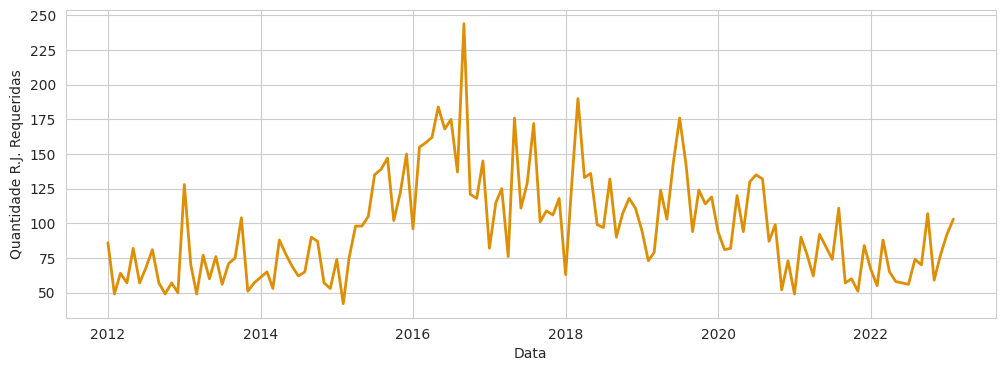

In [67]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize = (12, 4))
    ax.plot(df_serasa.index, df_serasa[('Recuperações Judiciais', 'Requeridas', 'Total')], lw = 2, color = paleta_cores[1])
    ax.set_xlabel('Data')
    ax.set_ylabel('Quantidade R.J. Requeridas')
    plt.show()

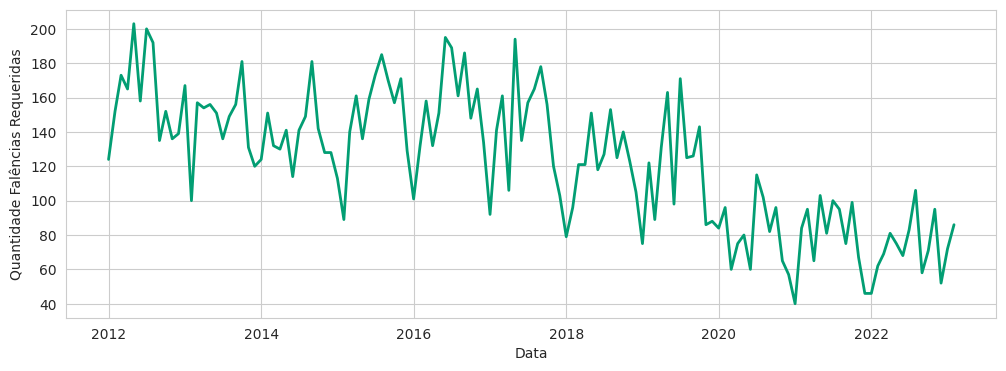

In [81]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize = (12, 4))
    ax.plot(df_serasa.index, df_serasa[('Falências', 'Requeridas', 'Total')], lw = 2, color = paleta_cores[2])
    ax.set_xlabel('Data')
    ax.set_ylabel('Quantidade Falências Requeridas')
    plt.show()

In [76]:
df_serasa2 = df_serasa[[('Recuperações Judiciais', 'Requeridas', 'Total')]].copy()
df_serasa2.columns = ['RJ_Requeridas_Total']

df_qtd_emp2 = df_qtd_emp.copy()
df_qtd_emp2 = df_qtd_emp2.set_index('Data_Ref')

df_join = pd.concat([df_qtd_emp2, df_serasa2], axis = 1)
df_join = df_join[df_join.index < '2023-03-01']
df_join = df_join[df_join['Qtd_Empresas_Ativas'] > 0]
df_join['RJ_Requeridas_Total'] = df_join['RJ_Requeridas_Total'].fillna(0)

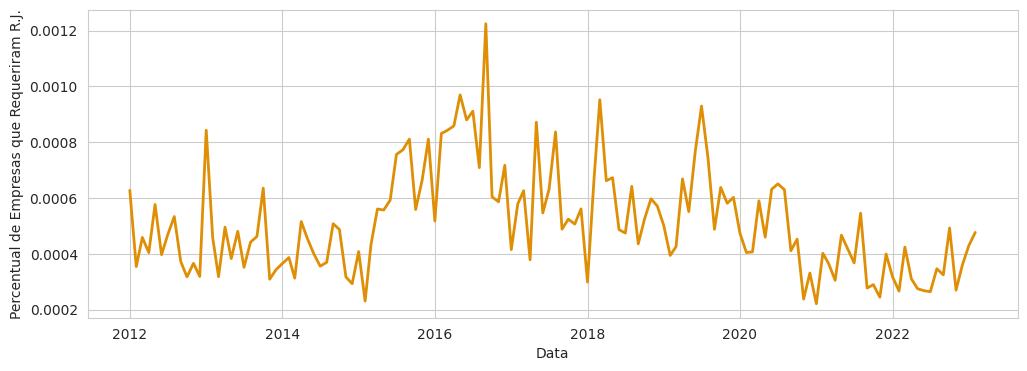

In [82]:
paleta_cores = sns.color_palette("colorblind")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize = (12, 4))
    ax.plot(df_join.index, df_join['RJ_Requeridas_Total']*100/df_join['Qtd_Empresas_Ativas'], lw = 2, color = paleta_cores[1])
    ax.set_xlabel('Data')
    ax.set_ylabel('Percentual de Empresas que Requeriram R.J.')
    plt.show()